In [1]:
!sudo apt-get install zstd
!curl -fsSL https://ollama.com/install.sh | sh
!nohup ollama serve > ollama.log &
!pip install --quiet -U openai ollama \
  langchain langchain_community langchain_core langchain_openai langchainhub langchain_elasticsearch langchain_ollama \
  transformers datasets python-dotenv tenacity google-search-results unstructured arxiv pymupdf tiktoken \
  streamlit streamlit-folium wikipedia jq ragas dspy \
  mcp langchain-mcp-adapters langgraph langchain_tavily langchain_experimental \
  langchain-chroma langchain-community google-search-results pymysql
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  zstd
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 603 kB of archives.
After this operation, 1,695 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 zstd amd64 1.4.8+dfsg-3build1 [603 kB]
Fetched 603 kB in 1s (551 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package zstd.
(Reading database ... 121689 files and directories currently i

In [2]:
from google.colab import drive
import json

drive.mount('/content/drive')
sample_path = '/content/drive/MyDrive/AI-scientist/NLP/과제/sample/synthetic_lifelog_60days.json'

with open(sample_path, "r", encoding="utf-8") as f:
    dataset = json.load(f)

print(f"Loaded {len(dataset)} days")
print("Example keys:", dataset[0].keys())

Mounted at /content/drive
Loaded 60 days
Example keys: dict_keys(['user_id', 'date', 'day_of_week', 'week_index', 'slot_minutes', 'observable', 'latent_factors'])


In [3]:
# 기본 설정
import os
from langchain_ollama import ChatOllama, OllamaEmbeddings

# Ollama가 실행 중인 서버 URL
BASE_URL = "http://localhost:11434"

# 💡 모델 선택
# - llama3.1: 일반적인 대화와 추론을 잘함 (문과생 느낌)
# - qwen2.5-coder: 코딩을 기가 막히게 잘함 (이과생 느낌)
#LLM_NAME = "llama3.1:8b"
LLM_NAME = "gemma3:4b"
EMBEDDING_NAME = "nomic-embed-text"


# 모델 다운로드 (최초 1회 실행 필요)
!ollama pull $LLM_NAME
!ollama pull $CODE_LLM_NAME
!ollama pull $EMBEDDING_NAME

# LangChain LLM 인스턴스 생성
llm = ChatOllama(
    model=LLM_NAME,
    temperature=0,
    base_url=BASE_URL
)

emb = OllamaEmbeddings(model="nomic-embed-text", base_url=BASE_URL)

print(f"준비 완료! 대화용 모델: {LLM_NAME},  임베딩 모델: {EMBEDDING_NAME}")


Error: accepts 1 arg(s), received 0

준비 완료! 대화용 모델: gemma3:4b,  임베딩 모델: nomic-embed-text


In [4]:
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS

def day_to_doc_text(record):
    ctx = record["observable"]["calendar_context"]
    slots = record["observable"]["slots"]
    lines = [f"day_of_week={ctx['day_of_week']}, week_index={ctx['week_index']}"]
    # 하루 슬롯을 그대로 직렬화
    for s in slots:
        lines.append(f"{s['ts']} {s['activity']}")
    return "\n".join(lines)

def build_day_vectorstore(dataset):
    docs = []
    for i, r in enumerate(dataset):
        text = day_to_doc_text(r)
        meta = {
            "date": r["date"],
            "day_of_week": r["day_of_week"],
            "week_index": r["week_index"],
            "day_idx": i
        }
        docs.append(Document(page_content=text, metadata=meta))
    vs = FAISS.from_documents(docs, emb)
    return vs

vectorstore = build_day_vectorstore(dataset)
print("Vectorstore built:", len(dataset), "docs")


Vectorstore built: 60 docs


In [5]:
VALID_ACTIVITIES = {
    "sleep","wake_up","breakfast","lunch","dinner",
    "work","gym","english_academy","relax_screen",
    "game","shower","sleep_winddown",
    "commute_subway","commute_taxi",
    "church_commute_subway","church_commute_taxi",
    "church_service","social_friend","social_family"
}

def normalize_pred(text: str) -> str:
    text = text.strip().lower()
    for a in VALID_ACTIVITIES:
        if a in text:
            return a
    return "unknown"

In [6]:
def infer_belief_from_history(record, t_idx, history_len=10):
    """
    Returns a small belief dict inferred ONLY from observable history.
    - rain_likely: bool
    - late_likely: bool (weekday only)
    """
    ctx = record["observable"]["calendar_context"]
    day = ctx["day_of_week"]
    slots = record["observable"]["slots"]

    start = max(0, t_idx - history_len)
    hist = slots[start:t_idx]
    acts = [h["activity"] for h in hist]

    # signals
    taxi = ("commute_taxi" in acts) or ("church_commute_taxi" in acts)
    subway = ("commute_subway" in acts) or ("church_commute_subway" in acts)

    # "late" signal: wake_up appears at 07:00 or later on weekdays in your generator
    late_signal = any(h["activity"] == "wake_up" and h["ts"] >= "07:00" for h in hist)

    # "rain" signal: taxi + (gym missing later is hard to know now), so use taxi + not late_signal as rain-ish
    if day in ["Mon","Tue","Wed","Thu","Fri"]:
        late_likely = late_signal
        rain_likely = taxi and not late_likely
    else:
        late_likely = False
        rain_likely = taxi  # weekend taxi mostly indicates rain in your rules

    return {"rain_likely": bool(rain_likely), "late_likely": bool(late_likely)}


In [7]:
def infer_belief_simple(record, t_idx, history_len=12):
    slots = record["observable"]["slots"]
    start = max(0, t_idx - history_len)
    hist = slots[start:t_idx]
    acts = [h["activity"] for h in hist]

    day = record["observable"]["calendar_context"]["day_of_week"]
    taxi = ("commute_taxi" in acts) or ("church_commute_taxi" in acts)
    late_signal = any(h["activity"] == "wake_up" and h["ts"] >= "07:00" for h in hist)

    if day in ["Mon","Tue","Wed","Thu","Fri"]:
        late_likely = late_signal
        rain_likely = taxi and not late_likely
    else:
        late_likely = False
        rain_likely = taxi

    return {"rain_likely": rain_likely, "late_likely": late_likely}


In [8]:
def retrieve_past_examples_rag_only(vectorstore, record, t_idx, history_len=6, k=4, fetch_k=12):
    query = build_rag_query(record, t_idx, history_len)  # 네 RAG-only에서 쓰던 query
    hits = vectorstore.similarity_search(query, k=fetch_k)

    from datetime import datetime
    def parse_date(s):
        return datetime.strptime(s, "%Y-%m-%d").date()

    cur_date = parse_date(record["date"])
    past = [d for d in hits if parse_date(d.metadata["date"]) < cur_date]
    return past[:k]


In [9]:
def rerank_docs_by_belief(docs, belief):
    def score(doc):
        text = doc.page_content
        s = 0
        if belief["rain_likely"]:
            # 비면 taxi가 문서에 있을 확률 높음
            s += 2 if "commute_taxi" in text or "church_commute_taxi" in text else 0
        else:
            s += 1 if "commute_subway" in text or "church_commute_subway" in text else 0

        if belief["late_likely"]:
            # 늦잠이면 wake_up이 07:00 이후에 나오기 쉬움(문서 텍스트 기반 간단 체크)
            s += 1 if "07:00 wake_up" in text or "07:30 wake_up" in text else 0

        return s
    return sorted(docs, key=score, reverse=True)


In [10]:
def build_rag_query(record, t_idx, history_len=6):
    ctx = record["observable"]["calendar_context"]
    slots = record["observable"]["slots"]
    start = max(0, t_idx - history_len)
    history = slots[start:t_idx]

    q = [f"day_of_week={ctx['day_of_week']}", f"week_index={ctx['week_index']}"]
    q.append("recent_history:")
    for h in history:
        q.append(f"{h['ts']} {h['activity']}")
    return "\n".join(q)

In [11]:
def build_prompt_only_prompt(record, t_idx, history_len=6):
    slots = record["observable"]["slots"]
    ctx = record["observable"]["calendar_context"]

    start = max(0, t_idx - history_len)
    history = slots[start:t_idx]

    prompt = f"""
You are predicting a user's next activity based on past behavior.

Calendar context:
- Day of week: {ctx['day_of_week']}
- Week index: {ctx['week_index']}

Recent activity history (30-minute intervals):
"""
    for h in history:
        prompt += f"- {h['ts']}: {h['activity']}\n"

    prompt += """
Task:
Predict the single most likely next 30-minute activity.

Rules:
- Output ONLY one activity label.
- Do not explain.
- Do not include extra text.

Answer:
"""
    return prompt

In [12]:
def build_rag_only_prompt(record, t_idx, retrieved_docs, history_len=6):
    ctx = record["observable"]["calendar_context"]
    slots = record["observable"]["slots"]
    start = max(0, t_idx - history_len)
    history = slots[start:t_idx]

    prompt = f"""
You are predicting the next 30-minute activity.
Use ONLY the retrieved past examples to help your prediction.

Current calendar context:
- Day of week: {ctx['day_of_week']}
- Week index: {ctx['week_index']}

Current recent history:
"""
    for h in history:
        prompt += f"- {h['ts']}: {h['activity']}\n"

    prompt += "\nRetrieved past day examples:\n"
    for j, d in enumerate(retrieved_docs, start=1):
        prompt += f"\n[Example {j}] date={d.metadata.get('date')} day_of_week={d.metadata.get('day_of_week')} week_index={d.metadata.get('week_index')}\n"
        # 너무 길면 잘라야 함 (Gemma 4B 컨텍스트 보호)
        prompt += d.page_content[:2500] + "\n"

    prompt += """
Task:
Predict the single most likely next 30-minute activity label.

Rules:
- Output ONLY one activity label from the label set.
- Do not explain.
- No extra text.

Answer:
"""
    return prompt

In [13]:
def build_agent_prompt(record, t_idx, belief, retrieved_docs, history_len=6):
    ctx = record["observable"]["calendar_context"]
    slots = record["observable"]["slots"]
    start = max(0, t_idx - history_len)
    history = slots[start:t_idx]

    prompt = f"""
You are an agent predicting the next 30-minute activity.
You have a belief about hidden conditions inferred from behavior (not given directly).

Belief (inferred from observable behavior):
- rain_likely: {belief['rain_likely']}
- late_wakeup_likely: {belief['late_likely']}

Current calendar context:
- Day of week: {ctx['day_of_week']}
- Week index: {ctx['week_index']}
- Current time: {slots[t_idx]['ts']}

Recent history:
"""
    for h in history:
        prompt += f"- {h['ts']}: {h['activity']}\n"

    prompt += "\nRetrieved past examples:\n"
    for j, d in enumerate(retrieved_docs, start=1):
        prompt += f"\n[Example {j}] date={d.metadata.get('date')} day_of_week={d.metadata.get('day_of_week')} week_index={d.metadata.get('week_index')}\n"
        prompt += d.page_content[:2500] + "\n"

    prompt += f"""
Task:
Predict the single most likely next 30-minute activity label.

Rules:
- Output ONLY one label from this set: {sorted(list(VALID_ACTIVITIES))}
- Do not explain.
- No extra text.

Answer:
"""
    return prompt


In [14]:
def build_agentic_v2_prompt(record, t_idx, belief, retrieved_docs, history_len=6):
    ctx = record["observable"]["calendar_context"]
    slots = record["observable"]["slots"]
    start = max(0, t_idx - history_len)
    history = slots[start:t_idx]

    prompt = f"""Predict the next 30-minute activity label.

Context:
- day_of_week: {ctx['day_of_week']}
- week_index: {ctx['week_index']}
- current_time: {slots[t_idx]['ts']}

Recent history:
"""
    for h in history:
        prompt += f"{h['ts']} {h['activity']}\n"

    prompt += f"""
Inferred hints (may be wrong):
- rain_likely={belief['rain_likely']}
- late_wakeup_likely={belief['late_likely']}

Retrieved examples:
"""
    for j, d in enumerate(retrieved_docs, start=1):
        prompt += f"\n[Ex{j}] {d.metadata.get('date')} {d.metadata.get('day_of_week')} week={d.metadata.get('week_index')}\n"
        prompt += d.page_content[:1500] + "\n"

    prompt += "\nOutput ONLY one activity label.\nAnswer:"
    return prompt


In [15]:
from datetime import datetime

def parse_date(s):
    return datetime.strptime(s, "%Y-%m-%d").date()

def retrieve_past_examples(vectorstore, record, t_idx, history_len=6, k=4, fetch_k=12):
    query = build_rag_query(record, t_idx, history_len)
    hits = vectorstore.similarity_search(query, k=fetch_k)

    cur_date = parse_date(record["date"])
    past = [d for d in hits if parse_date(d.metadata["date"]) < cur_date]

    # 과거가 부족하면 그냥 가능한 만큼만
    return past[:k]

In [16]:
def build_agent_query(record, t_idx, belief, history_len=6):
    ctx = record["observable"]["calendar_context"]
    slots = record["observable"]["slots"]
    start = max(0, t_idx - history_len)
    history = slots[start:t_idx]

    q = []
    q.append(f"day_of_week={ctx['day_of_week']}")
    q.append(f"week_index={ctx['week_index']}")
    q.append(f"belief_rain_likely={belief['rain_likely']}")
    q.append(f"belief_late_likely={belief['late_likely']}")
    q.append(f"current_time={slots[t_idx]['ts']}")
    q.append("recent_history:")
    for h in history:
        q.append(f"{h['ts']} {h['activity']}")
    return "\n".join(q)


In [17]:
def predict_next_activity_prompt_only(record, t_idx, history_len=6):
    prompt = build_prompt_only_prompt(record, t_idx, history_len)
    raw = llm.invoke(prompt).content
    return normalize_pred(raw)

In [18]:
def predict_next_activity_rag_only(record, t_idx, history_len=6, k=4):
    docs = retrieve_past_examples(vectorstore, record, t_idx, history_len, k=k)
    prompt = build_rag_only_prompt(record, t_idx, docs, history_len)
    raw = llm.invoke(prompt).content
    return normalize_pred(raw)

In [19]:
def predict_next_activity_agentic(record, t_idx, history_len=6, belief_hist_len=10, k=4):
    belief = infer_belief_from_history(record, t_idx, history_len=belief_hist_len)
    docs = retrieve_past_examples_agent(vectorstore, record, t_idx, belief, history_len=history_len, k=k)
    prompt = build_agent_prompt(record, t_idx, belief, docs, history_len=history_len)
    raw = llm.invoke(prompt).content
    return normalize_pred(raw)


In [20]:
def predict_next_activity_agentic_v2(record, t_idx, history_len=6, k=4):
    belief = infer_belief_simple(record, t_idx, history_len=12)
    docs = retrieve_past_examples_rag_only(vectorstore, record, t_idx, history_len=history_len, k=k, fetch_k=16)
    docs = rerank_docs_by_belief(docs, belief)[:k]
    prompt = build_agentic_v2_prompt(record, t_idx, belief, docs, history_len=history_len)
    raw = llm.invoke(prompt).content
    return normalize_pred(raw)


In [21]:
from tqdm.auto import tqdm
import time

def evaluate_on_samples(samples, dataset, predict_fn, desc="eval"):
    correct = 0
    total = 0
    t0 = time.time()
    pbar = tqdm(total=len(samples), desc=desc, unit="call")

    for (ri, t_idx) in samples:
        record = dataset[ri]
        gt = record["observable"]["slots"][t_idx]["activity"]
        pred = predict_fn(record, t_idx)

        correct += (pred == gt)
        total += 1

        elapsed = time.time() - t0
        ips = total / elapsed if elapsed > 0 else 0.0
        acc = correct / total if total else 0.0
        pbar.update(1)
        pbar.set_postfix(acc=f"{acc:.3f}", it_s=f"{ips:.2f}")

    pbar.close()
    acc = correct / total if total else 0.0
    print(f"DONE: acc={acc:.4f} ({correct}/{total})")
    return acc

In [22]:
import random
def make_eval_samples(dataset, history_len=6, start_slot=10, end_slot=42, n=240, seed=42):
    random.seed(seed)
    candidates = []
    for ri, record in enumerate(dataset):
        slots = record["observable"]["slots"]
        for t_idx in range(start_slot, min(end_slot, len(slots))):
            if t_idx >= history_len:
                candidates.append((ri, t_idx))
    return random.sample(candidates, min(n, len(candidates)))

In [23]:
from tqdm.auto import tqdm
import random, time

def evaluate_prompt_only_sampled_tqdm(
    dataset,
    history_len=6,
    start_slot=10,
    end_slot=42,
    day_sample=20,
    slots_per_day=6,
    max_calls=300,
    seed=42
):
    random.seed(seed)
    days = dataset[:]
    if day_sample is not None and day_sample < len(days):
        days = random.sample(days, day_sample)

    correct = 0
    total = 0
    t0 = time.time()

    pbar = tqdm(total=max_calls, desc="Prompt-only eval", unit="call")

    for record in days:
        slots = record["observable"]["slots"]
        candidate_idxs = list(range(start_slot, min(end_slot, len(slots))))
        chosen = random.sample(candidate_idxs, min(slots_per_day, len(candidate_idxs)))

        for t_idx in chosen:
            gt = slots[t_idx]["activity"]
            pred = predict_next_activity_prompt_only(record, t_idx, history_len)

            correct += (pred == gt)
            total += 1
            pbar.update(1)

            # 실시간 지표 표시
            acc = correct / total if total else 0.0
            elapsed = time.time() - t0
            ips = total / elapsed if elapsed > 0 else 0.0
            pbar.set_postfix(acc=f"{acc:.3f}", it_s=f"{ips:.2f}")

            if total >= max_calls:
                pbar.close()
                print(f"DONE (max_calls): acc={acc:.4f} ({correct}/{total})")
                return acc

    pbar.close()
    acc = correct / total if total else 0.0
    print(f"DONE: acc={acc:.4f} ({correct}/{total})")
    return acc

In [24]:
from tqdm.auto import tqdm
import time

def evaluate_on_samples(samples, dataset, predict_fn, desc="eval"):
    correct = 0
    total = 0
    t0 = time.time()
    pbar = tqdm(total=len(samples), desc=desc, unit="call")

    for (ri, t_idx) in samples:
        record = dataset[ri]
        gt = record["observable"]["slots"][t_idx]["activity"]
        pred = predict_fn(record, t_idx)

        correct += (pred == gt)
        total += 1

        elapsed = time.time() - t0
        ips = total / elapsed if elapsed > 0 else 0.0
        acc = correct / total if total else 0.0
        pbar.update(1)
        pbar.set_postfix(acc=f"{acc:.3f}", it_s=f"{ips:.2f}")

    pbar.close()
    acc = correct / total if total else 0.0
    print(f"DONE: acc={acc:.4f} ({correct}/{total})")
    return acc

In [25]:
from datetime import datetime

def parse_date(s):
    return datetime.strptime(s, "%Y-%m-%d").date()

def retrieve_past_examples_agent(vectorstore, record, t_idx, belief, history_len=6, k=4, fetch_k=16):
    query = build_agent_query(record, t_idx, belief, history_len)
    hits = vectorstore.similarity_search(query, k=fetch_k)

    cur_date = parse_date(record["date"])
    past = [d for d in hits if parse_date(d.metadata["date"]) < cur_date]
    return past[:k]

In [26]:
prompt_acc = evaluate_prompt_only_sampled_tqdm(
    dataset,
    day_sample=40,
    slots_per_day=6,
    max_calls=240
)


Prompt-only eval:   0%|          | 0/240 [00:00<?, ?call/s]

DONE (max_calls): acc=0.5792 (139/240)


In [27]:
samples = make_eval_samples(dataset, history_len=6, n=240, seed=42)

# RAG-only
rag_acc = evaluate_on_samples(
    samples,
    dataset,
    predict_fn=lambda r, t: predict_next_activity_rag_only(r, t, history_len=6, k=4),
    desc="RAG-only eval"
)

print("RAG-only acc:", rag_acc)

RAG-only eval:   0%|          | 0/240 [00:00<?, ?call/s]

DONE: acc=0.6500 (156/240)
RAG-only acc: 0.65


In [28]:
samples = make_eval_samples(dataset, history_len=6, n=240, seed=42)

agent_acc = evaluate_on_samples(
    samples, dataset,
    predict_fn=lambda r,t: predict_next_activity_agentic(r,t, history_len=6, k=4),
    desc="Agentic eval"
)


Agentic eval:   0%|          | 0/240 [00:00<?, ?call/s]

DONE: acc=0.5833 (140/240)


In [29]:

samples = make_eval_samples(dataset, history_len=6, n=240, seed=42)
agent2_acc = evaluate_on_samples(
    samples, dataset,
    predict_fn=lambda r,t: predict_next_activity_agentic_v2(r,t, history_len=6, k=4),
    desc="Agentic-v2 eval"
)


Agentic-v2 eval:   0%|          | 0/240 [00:00<?, ?call/s]

DONE: acc=0.6792 (163/240)


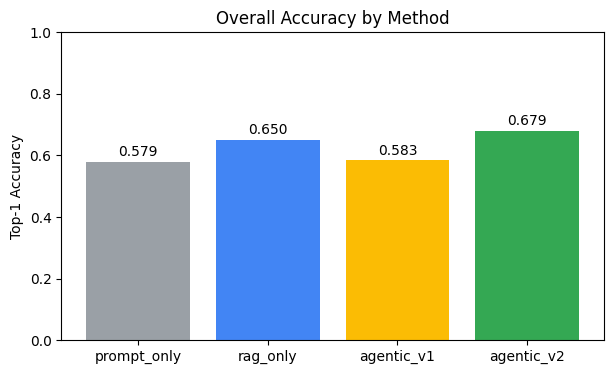

In [47]:
import matplotlib.pyplot as plt
acc = {
    "prompt_only": prompt_acc,
    "rag_only": rag_acc,
    "agentic_v1": agent_acc,
    "agentic_v2": agent2_acc
}

methods = list(acc.keys())
values = list(acc.values())

colors = [
    "#9aa0a6",  # prompt_only - 회색 (baseline)
    "#4285f4",  # rag_only - 파랑
    "#fbbc04",  # agentic_v1 - 노랑
    "#34a853",  # agentic_v2 - 초록 (best)
]

plt.figure(figsize=(7, 4))
bars = plt.bar(methods, values, color=colors)

plt.ylabel("Top-1 Accuracy")
plt.title("Overall Accuracy by Method")
plt.ylim(0, 1.0)

# 🔢 막대 위에 수치 표시
for bar, val in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

# rag_baseline = acc["rag_only"]
# plt.axhline(
#     y=rag_baseline,
#     linestyle="--",
#     linewidth=1,
# )
# plt.text(
#     len(methods)-0.5,
#     rag_baseline + 0.005,
#     "RAG baseline",
#     ha="right",
#     va="bottom",
#     fontsize=9
# )

plt.xticks(rotation=0)
plt.show()

In [30]:
from tqdm.auto import tqdm
import time

def acc_by_regime_tqdm(samples, dataset, predict_fn, name="model"):
    # 그룹 나누기
    groups = {"weekday": [], "sat": [], "sun": []}
    for ri, t_idx in samples:
        day = dataset[ri]["observable"]["calendar_context"]["day_of_week"]
        if day in ["Mon","Tue","Wed","Thu","Fri"]:
            groups["weekday"].append((ri, t_idx))
        elif day == "Sat":
            groups["sat"].append((ri, t_idx))
        else:
            groups["sun"].append((ri, t_idx))

    results = {}

    print(f"\n[{name}] accuracy by regime\n")

    for regime, gsamples in groups.items():
        correct = 0
        total = 0
        unknown = 0
        t0 = time.time()

        pbar = tqdm(
            gsamples,
            desc=f"{name} | {regime}",
            unit="sample",
            leave=True
        )

        for ri, t_idx in pbar:
            r = dataset[ri]
            gt = r["observable"]["slots"][t_idx]["activity"]
            pred = predict_fn(r, t_idx)

            if pred == "unknown":
                unknown += 1
            if pred == gt:
                correct += 1
            total += 1

            acc = correct / total if total else 0.0
            unk = unknown / total if total else 0.0
            elapsed = time.time() - t0
            ips = total / elapsed if elapsed > 0 else 0.0

            pbar.set_postfix(
                acc=f"{acc:.3f}",
                unknown=f"{unk:.2f}",
                it_s=f"{ips:.2f}"
            )

        pbar.close()

        acc = correct / total if total else 0.0
        unk = unknown / total if total else 0.0
        results[regime] = (acc, unk, total)

        print(f"- {regime:7s}: acc={acc:.4f}, unknown={unk:.3f}, n={total}")

    return results


In [48]:
rag_res = acc_by_regime_tqdm(
    samples,
    dataset,
    predict_fn=lambda r,t: predict_next_activity_rag_only(r,t, history_len=6, k=4),
    name="RAG-only"
)

agent2_res = acc_by_regime_tqdm(
    samples,
    dataset,
    predict_fn=lambda r,t: predict_next_activity_agentic_v2(r,t, history_len=6, k=4),
    name="Agentic-v2"
)


[RAG-only] accuracy by regime



RAG-only | weekday:   0%|          | 0/169 [00:00<?, ?sample/s]

- weekday: acc=0.7101, unknown=0.000, n=169


RAG-only | sat:   0%|          | 0/29 [00:00<?, ?sample/s]

- sat    : acc=0.5172, unknown=0.000, n=29


RAG-only | sun:   0%|          | 0/42 [00:00<?, ?sample/s]

- sun    : acc=0.5000, unknown=0.000, n=42

[Agentic-v2] accuracy by regime



Agentic-v2 | weekday:   0%|          | 0/169 [00:00<?, ?sample/s]

- weekday: acc=0.7456, unknown=0.000, n=169


Agentic-v2 | sat:   0%|          | 0/29 [00:00<?, ?sample/s]

- sat    : acc=0.4138, unknown=0.000, n=29


Agentic-v2 | sun:   0%|          | 0/42 [00:00<?, ?sample/s]

- sun    : acc=0.5952, unknown=0.000, n=42


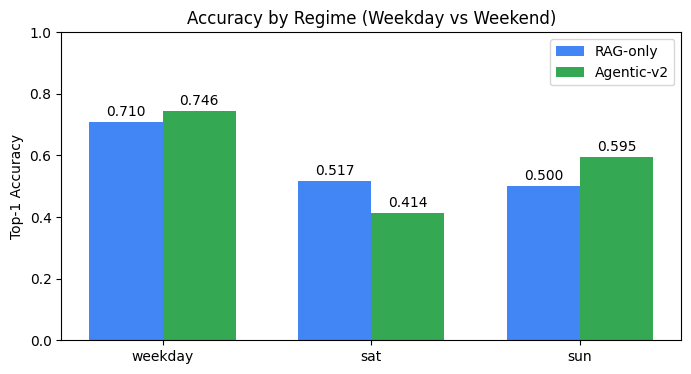

In [49]:
import matplotlib.pyplot as plt

def acc_only(res):
    # res: {"weekday": (acc, unk, n), ...}
    return {k: float(v[0]) for k, v in res.items()}

rag_acc = acc_only(rag_res)
agent_acc = acc_only(agent2_res)

regimes = ["weekday", "sat", "sun"]
methods = ["RAG-only", "Agentic-v2"]
scores = {
    "RAG-only": [rag_acc[r] for r in regimes],
    "Agentic-v2": [agent_acc[r] for r in regimes]
}

x = list(range(len(regimes)))
width = 0.35

plt.figure(figsize=(8,4))

bars1 = plt.bar([p - width/2 for p in x], scores["RAG-only"], width=width, color="#4285f4", label="RAG-only")
bars2 = plt.bar([p + width/2 for p in x], scores["Agentic-v2"], width=width, color="#34a853", label="Agentic-v2")

plt.xticks(x, regimes)
plt.ylim(0, 1.0)
plt.ylabel("Top-1 Accuracy")
plt.title("Accuracy by Regime (Weekday vs Weekend)")
plt.legend()

# 값 표시
for bars in [bars1, bars2]:
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h + 0.01, f"{h:.3f}", ha="center", va="bottom", fontsize=10)

plt.show()


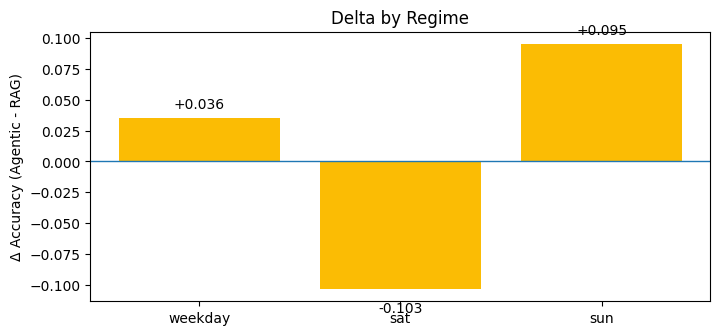

In [50]:
delta = [agent_acc[r] - rag_acc[r] for r in regimes]

plt.figure(figsize=(8,3.5))
bars = plt.bar(regimes, delta, color="#fbbc04")
plt.axhline(0, linewidth=1)

plt.ylabel("Δ Accuracy (Agentic - RAG)")
plt.title("Delta by Regime")

for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + (0.005 if h>=0 else -0.01), f"{h:+.3f}",
             ha="center", va="bottom" if h>=0 else "top", fontsize=10)

plt.show()


In [32]:
def filter_samples_by_time(samples, dataset, day="Sat", start_ts="17:30", end_ts="21:00"):
    out = []
    for ri, t_idx in samples:
        r = dataset[ri]
        dow = r["observable"]["calendar_context"]["day_of_week"]
        ts = r["observable"]["slots"][t_idx]["ts"]
        if dow == day and start_ts <= ts < end_ts:
            out.append((ri, t_idx))
    return out

In [33]:
def retrieve_past_examples_rag_only_fetch(vectorstore, record, t_idx, history_len=6, fetch_k=60):
    query = build_rag_query(record, t_idx, history_len)
    hits = vectorstore.similarity_search(query, k=fetch_k)

    cur_date = parse_date(record["date"])
    past = [d for d in hits if parse_date(d.metadata["date"]) < cur_date]
    return past

In [34]:
def tag_social(doc):
    txt = doc.page_content
    if "social_friend" in txt: return "friend"
    if "social_family" in txt: return "family"
    return "none"

def debug_one_case_rag(record, t_idx, fetch_k=20, k_show=8):
    ts = record["observable"]["slots"][t_idx]["ts"]
    print(f"\nCASE date={record['date']} dow={record['day_of_week']} week={record['week_index']} ts={ts}")
    docs = retrieve_past_examples_rag_only_fetch(vectorstore, record, t_idx, history_len=6, fetch_k=fetch_k)

    for i, d in enumerate(docs[:k_show], 1):
        print(f"{i}. date={d.metadata['date']} dow={d.metadata.get('day_of_week')} week={d.metadata.get('week_index')} tag={tag_social(d)}")

In [35]:

sat_evening = filter_samples_by_time(
    samples,
    dataset,
    day="Sat",
    start_ts="17:30",
    end_ts="21:00"
)
ri, t_idx = sat_evening[0]
debug_one_case_rag(dataset[ri], t_idx)


CASE date=2026-04-11 dow=Sat week=6 ts=19:30
1. date=2026-03-28 dow=Sat week=4 tag=family
2. date=2026-03-07 dow=Sat week=1 tag=friend
3. date=2026-03-14 dow=Sat week=2 tag=family
4. date=2026-03-08 dow=Sun week=1 tag=none
5. date=2026-03-21 dow=Sat week=3 tag=friend
6. date=2026-04-05 dow=Sun week=5 tag=none
7. date=2026-04-06 dow=Mon week=6 tag=none
8. date=2026-04-08 dow=Wed week=6 tag=none
